In [1]:
import imgaug as ia
print(ia.__version__)

0.4.0


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import imgaug.augmenters as iaa

import torch
import torchvision

from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


DIR_INPUT = './data'
DIR_TRAIN = f'{DIR_INPUT}/train'

In [3]:
train_csv = pd.read_csv(os.path.join(DIR_INPUT, "wheat.csv") ,index_col=0)
if not np.any(train_csv.notnull()) == True:
    train_csv = train_csv.dropna(axis=0, how='any')
    print("Drop Nan")
train_csv = train_csv.reset_index()
train_csv.head()

,image_id,width,height,source,x_min,y_min,x_max,y_max,class
0,b6ab77fd7,56.0,36.0,usask_1,834.0,222.0,890.0,258.0,1
1,b6ab77fd7,130.0,58.0,usask_1,226.0,548.0,356.0,606.0,1
2,b6ab77fd7,74.0,160.0,usask_1,377.0,504.0,451.0,664.0,1
3,b6ab77fd7,109.0,107.0,usask_1,834.0,95.0,943.0,202.0,1
4,b6ab77fd7,124.0,117.0,usask_1,26.0,144.0,150.0,261.0,1


In [4]:
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.x_min, row.y_min, row.width, row.height))
        
    return bboxes

In [5]:
class WheatTestDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None, mode="train"):
        super().__init__()
        self.image_ids = df["image_id"].unique()
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        self.mode = mode
        
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]

        records = self.df[self.df["image_id"] == image_id]
        if os.path.exists(os.path.join(self.img_dir, image_id+".jpg")):
            img_path = os.path.join(self.img_dir, image_id+".jpg")
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            img = img/255.0
        
        target = dict()        

        if self.mode == "train":
            bboxes = get_all_bboxes(self.df, image_id)         
            
            BBoxes = []
            for [x, y, w, h] in bboxes:
                BBoxes.append(BoundingBox(x1=x, x2=x+w, y1=y, y2=y+h))
                bbs = BoundingBoxesOnImage(BBoxes, shape=img.shape)

            # Apply augmentations
            if self.transforms:
                image_aug, bbs_aug = self.transforms(image=img, bounding_boxes=bbs)
            else:
                image_aug, bbs_aug = img, bbs

            boxes = torch.as_tensor([box.coords.reshape(4) for box in bbs_aug.bounding_boxes], dtype=torch.float32)
            target["boxes"] = boxes
            
            
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            target['area'] = area
#             target['image_id'] = image_id

            
            # there is only one class
            labels = torch.ones((records.shape[0],), dtype=torch.int64)
            target['labels'] = labels
        
#             image_before = bbs.draw_on_image(img, size=5)
#             image_after = bbs_aug.draw_on_image(image_aug, size=5, color=[0, 255, 255])
#             fig, axes = plt.subplots(2, 1, figsize=(20, 15))
#             plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8, hspace=0.3, wspace=0.0)
#             axes[0].set_title("image before")
#             axes[0].imshow(image_before)
#             axes[1].set_title("image after augmentation")
#             axes[1].imshow(image_after)
            
            img = transforms.functional.to_tensor(image_aug.copy())
            
            return img, target, image_id
        else:
            img = transforms.functional.to_tensor(img).unsqueeze(0)
            return img, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

## Transform Images

In [6]:
train_trf = iaa.Sequential([
                            iaa.flip.Fliplr(p=0.5), 
                            iaa.flip.Flipud(p=0.5),
                            iaa.GammaContrast((1.0, 2.0)),   
                            iaa.CropToSquare()
#                             iaa.size.Resize({"height": 512, "width": 512}),
                            ])

In [7]:
total_dataset = train_csv["image_id"].unique()

train_ids, valid_ids = train_test_split(total_dataset, test_size = 0.2)

train_df = train_csv[train_csv['image_id'].isin(train_ids)]
valid_df = train_csv[train_csv['image_id'].isin(valid_ids)]
train_df.reset_index(inplace=True)
valid_df.reset_index(inplace=True)

train_dataset = WheatTestDataset(train_df, DIR_TRAIN, train_trf)
valid_dataset = WheatTestDataset(valid_df, DIR_TRAIN, transforms=None)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [8]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [9]:
def iou(box1, box2):
    x11, y11, x12, y12 = box1
    x21, y21, x22, y22 = box2

    w1, h1 = x12 - x11, y12 - y11
    w2, h2 = x22 - x21, y22 - y21
    
    assert w1 * h1 > 0
    assert w2 * h2 > 0

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union
    
def iou2(box1, box2):
    x11, y11, w1, h1 = box1
    x21, y21, w2, h2 = box2
    assert w1 * h1 > 0
    assert w2 * h2 > 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union

x1, y1, w1, h1 = 100, 100, 200, 200
x2, y2, w2, h2 = 100, 100, 300, 200

print(iou([x1, y1, w1+x1, h1+y1], [x2, y2, w2+x2, h2+y2]))
print(iou2([x1, y1, w1, h1], [x2, y2, w2, h2]))

0.6666666666666666
0.6666666666666666


## Mean Average Precision¶
This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds.

The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.75 with a step size of 0.05. In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.

Precision(t) = TP(t) / ( TP(t) + FP(t) + FN(t) )

In [10]:
def map_iou(boxes_true, boxes_pred, scores, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    Mean average precision at differnet intersection over union (IoU) threshold
    
    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output: 
        map: mean average precision of the image
    """
    
    # According to the introduction, images with no ground truth bboxes will not be 
    # included in the map score unless there is a false positive detection (?)
        
    # return None if both are empty, don't count the image in final evaluation (?)
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return None
    
    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]
    
    map_total = 0
    
    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = iou(bt, bp)
                
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN
        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)

        map_total += m
    
    return map_total / len(thresholds)


x1, y1, w1, h1 = 100, 100, 200, 200
x2, y2, w2, h2 = 100, 100, 300, 200
scores = [0.9]

print(map_iou(np.array([[x1, y1, w1+x1, h1+y1]]), np.array([[x2, y2, w2+x2, h2+y2]]), scores))

0.75


In [11]:
torch.cuda.empty_cache()

model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.8MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100%|██████████| 159M/159M [00:14<00:00, 11.5MB/s] 


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
num_classes = 2  # 1 class (wheat) + background


print(model)
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features

# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

cuda
DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout):

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

cuda


In [19]:
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

init_loss = np.inf
init_mAP = 0
init_epoch = 0

In [23]:
if os.path.exists(os.path.join(weight_folder, mAP_weight)):
    print("Load Pre-trained mAP")
    mAP_checkpoint = torch.load(os.path.join(weight_folder, mAP_weight))
    init_mAP = mAP_checkpoint["mAP"]
    if init_mAP > 1:
        init_mAP = 0
    
    print("mAP Weight Info: epoch {} , loss {:.3f}, mAP {:.3f} ".format(mAP_checkpoint["epoch"],
                                                                        mAP_checkpoint["loss"],
                                                                        mAP_checkpoint["mAP"]))



if os.path.exists(os.path.join(weight_folder, min_loss_weight)):
    print("Load Pre-trained minloss")
    minloss_checkpoint = torch.load(os.path.join(weight_folder, min_loss_weight))
    init_epoch = minloss_checkpoint["epoch"]
    init_loss = minloss_checkpoint["loss"]
    model.load_state_dict(minloss_checkpoint["model_state_dict"])
#     optimizer.load_state_dict(minloss_checkpoint["optimizer_state_dict"])
    
    print("minloss Weight Info: epoch {} , loss {:.3f}, mAP {:.3f} ".format(minloss_checkpoint["epoch"],
                                                                            minloss_checkpoint["loss"],
                                                                            minloss_checkpoint["mAP"]))

Load Pre-trained mAP
mAP Weight Info: epoch 100 , loss 0.531, mAP 2.615 
Load Pre-trained minloss
minloss Weight Info: epoch 81 , loss 0.531, mAP 2.619 


## Train model

In [24]:
def validation(valid_loader, model):
    model.eval()
    map_value = 0
    count = 0
    for images, targets, image_id in valid_loader:
        
        with torch.no_grad():
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            output = model(images)
            for i in range(len(output)):   
                boxes_pred = output[i]["boxes"].cpu().numpy() #[x1, y1,x2, y2]
                
                boxes_scores = output[i]['scores'].data.cpu().numpy()
                boxes_true = targets[i]["boxes"].cpu().numpy()
                
                map_value += map_iou(boxes_true, boxes_pred, boxes_scores, thresholds =[0.5])

                
                
    return map_value / (len(valid_loader)*len(output))

In [25]:
loss_hist = Averager()
itr = 1
num_epochs =25
import math
print("init config: init_loss: {} epoch: {}, mAP: {}".format(init_loss, init_epoch, init_mAP))

for epoch in range(num_epochs):
    print("=== Epoch: {} ===".format(epoch))
    loss_hist.reset()
    
    model.train()
    for images, targets, image_id in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        train_loss_dict = model(images, targets)
        
        losses = sum(loss for loss in train_loss_dict.values())
        
        loss_hist.send(losses.item())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if itr % 30 == 0:
            print(f"Iteration #{itr} loss: {loss_hist.value}")
        itr += 1
    
    
    mAP_value = validation(valid_loader, model)
    
    if init_loss > loss_hist.value:
        print("Save min loss weights ==> loss {}, mAP {}".format(loss_hist.value, mAP_value))
        init_loss = loss_hist.value
        init_epoch = init_epoch + epoch + 1
        
        torch.save({"mAP": mAP_value,
            'epoch': init_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': init_loss}, os.path.join(weight_folder, min_loss_weight))
        

    
    if init_mAP < mAP_value:
        print("Save mAP weights ==> loss {}, mAP {}".format(loss_hist.value, mAP_value))
        
        init_epoch = init_epoch + epoch + 1
        init_mAP = mAP_value
        
        torch.save({"mAP": init_mAP,
            'epoch': init_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_hist.value}, os.path.join(weight_folder, mAP_weight))
        
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
        
    print(f"Epoch #{epoch} loss: {loss_hist.value} / ({init_loss}) mAP: {mAP_value}") 

init config: init_loss: 0.5313010790644312 epoch: 81, mAP: 0
=== Epoch: 0 ===
Iteration #30 loss: 0.5242686529954275
Iteration #60 loss: 0.5306952074170113
Iteration #90 loss: 0.5357541941934162
Iteration #120 loss: 0.5369801826775074
Iteration #150 loss: 0.5364927212397258


KeyboardInterrupt: 

## validate date

In [27]:
selected_id = 0
images, targets, image_ids = next(iter(valid_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

print(len(images), len(targets), image_ids)

4 4 ('7b72ea0fb', 'c682d8c66', 'e46378032', '0435654cd')


In [28]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
model.eval()
# cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
print(len(outputs))
out = outputs[0]["boxes"].cpu().detach().numpy().astype(np.int)
print(out[0])

4
[688  84 813 225]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


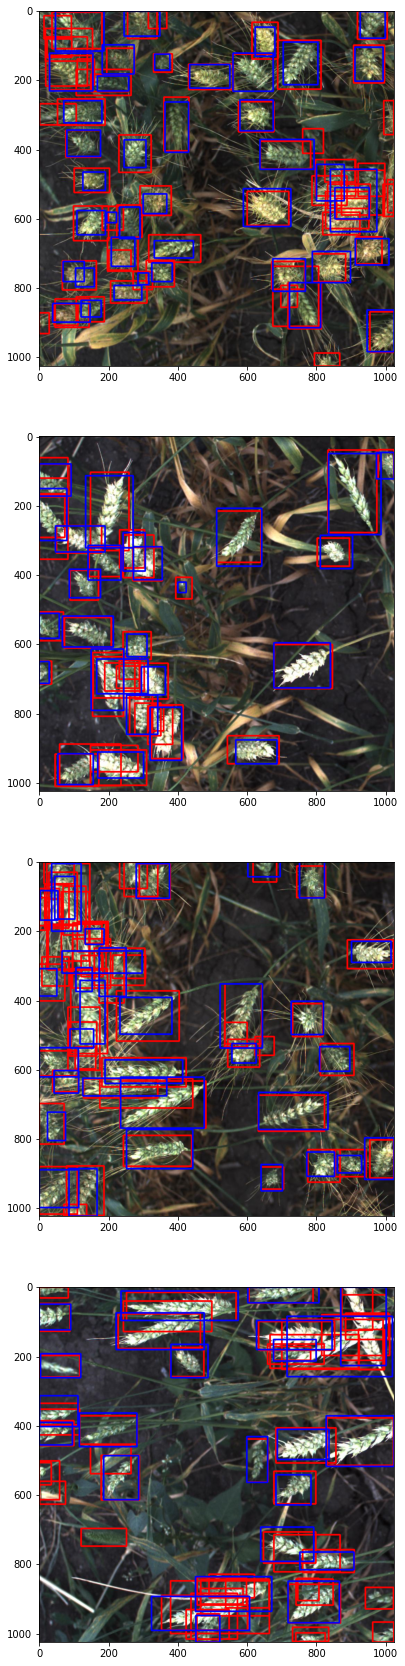

In [29]:
fig, axes = plt.subplots(4, 1, figsize=(40, 30))
for i in range(len(outputs)):
    sample = images[i].permute(1,2,0).cpu().numpy()
    for pred in outputs[i]["boxes"].cpu().detach().numpy().astype(np.int):
        
        sample = cv2.rectangle(sample,
                      (pred[0], pred[1]),
                      (pred[2], pred[3]),
                      (220, 0, 0), 3)

    for gt in targets[i]['boxes'].cpu().numpy().astype(np.int32):
        sample = cv2.rectangle(sample,
                      (gt[0], gt[1]),
                      (gt[2], gt[3]),
                      (0, 0, 255), 3)
    axes[i].imshow(sample)
plt.show()
